In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sys
from tqdm import tqdm
sys.path.append('../../../src')

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
seed = 64
np.random.seed(seed)

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

# Indivisual Activity をロード

In [4]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [5]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [6]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [7]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 11.39it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 15.35it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.88it/s]


# SVM
## 特徴量抽出とデータ生成

In [8]:
def extract_features(frame_num, label1, label2, individuals):
    if label1 not in individuals or label2 not in individuals:
        return None
        
    individual1 = individuals[label1]
    pos1 = individual1.get_indicator('position', frame_num)
    body1 = individual1.get_indicator('body_vector', frame_num)
    arm1 = individual1.get_indicator('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_indicator('position', frame_num)
    body2 = individual2.get_indicator('body_vector', frame_num)
    arm2 = individual2.get_indicator('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig']
    )
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig']
    )

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]

columns = ['distance', 'body', 'arm', 'wrist']

In [9]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            if features is not None:
                x_dict[key].append(features)
                y_dict[key].append(row[3])

09, 20210706, 09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2833/2833 [00:00<00:00, 15849.35it/s]


## 分布をプロット

In [177]:
def plot_feature(x_train, y_train, path=None):
    x_true = np.array(x_train)[np.where(np.array(y_train) == 1)].T
    x_false = np.array(x_train)[np.where(np.array(y_train) == 0)].T

    # 分布をプロット
    def set_ax(ax, column_i, column_j, title=None):
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel(column_i)
        ax.set_ylabel(column_j)
        ax.set_xlim((0, 1))
        ax.set_xticks([0, 1])
        ax.set_ylim((0, 1))
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['', 1])

    n = int(len(columns) * (len(columns) - 1) / 2)  # 組み合わせ: len(columns) C 2

    fig = plt.figure(figsize=(10, n * 5))
    ax_count = 1
    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            ax = fig.add_subplot(n, 2, ax_count * 2 - 1)
            ax.scatter(x_true[i], x_true[j], color='red', s=1)
            if i == 0 and j == 1:
                set_ax(ax, columns[i], columns[j], 'Passing')
            else:
                set_ax(ax, columns[i], columns[j])

            ax = fig.add_subplot(n, 2, ax_count * 2)
            ax.scatter(x_false[i], x_false[j], s=1)
            if i == 0 and j == 1:
                set_ax(ax, columns[i], columns[j], 'Not Passing')
            else:
                set_ax(ax, columns[i], columns[j])

            ax_count += 1
            
    fig.subplots_adjust(hspace=0.3)
    if path is not None:
        fig.subplots_adjust(left=0.08, right=0.95, bottom=0.02, top=0.98)
        fig.savefig(path)

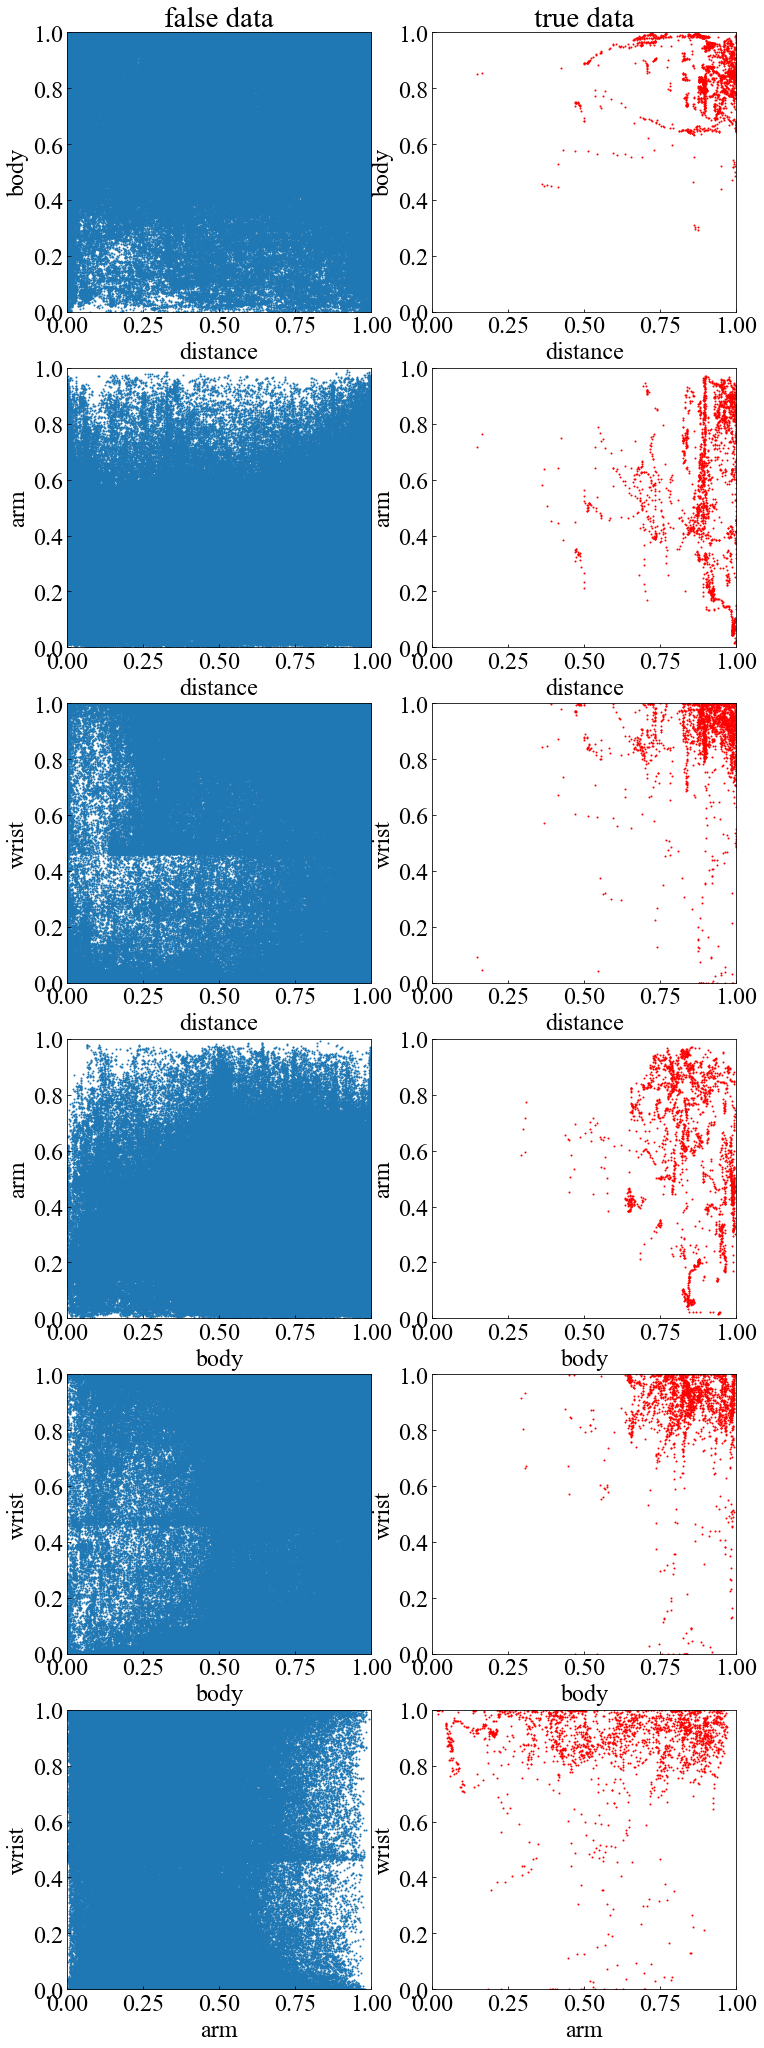

In [178]:
# データを整形
x_lst = []
y_lst = []
for x, y in zip(x_dict.values(), y_dict.values()):
    x_lst += x
    y_lst += y
path = os.path.join(common.data_dir, "image", "passing", 'features.pdf')
plot_feature(x_lst, y_lst, path)

## 学習・検証

In [12]:
from sklearn.svm import SVC

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import pickle

## 模擬実験のモデルで検証

## データセット作成

In [13]:
train_ratio = 0.7
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)
train_len = int(len(x_dict) * train_ratio)
train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}
x_train = []
y_train = []
for x, y in zip(x_train_dict.values(), y_train_dict.values()):
    x_train += x
    y_train += y

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}
x_test = []
y_test = []
for x, y in zip(x_test_dict.values(), y_test_dict.values()):
    x_test += x
    y_test += y

# x_train = scale(x_train)

In [14]:
len_pass = len([i for i in y_lst if i == 1])
len_not_pass = len([i for i in y_lst if i == 0])

print(f'all length:{len(y_lst)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

all length:452523
passing: 2059
not passing: 450464


In [15]:
len_pass_train = len([i for i in y_train if i == 1])
len_not_pass_train = len([i for i in y_train if i == 0])

print(f'train length:{len(y_train)}')
print(f'passing: {len_pass_train}')
print(f'not passing: {len_not_pass_train}')

train length:324394
passing: 1554
not passing: 322840


In [16]:
len_pass_test = len([i for i in y_test if i == 1])
len_not_pass_test = len([i for i in y_test if i == 0])

print(f'test length:{len(y_test)}')
print(f'passing: {len_pass_test}')
print(f'not passing: {len_not_pass_test}')

test length:128129
passing: 505
not passing: 127624


In [175]:
# パスかどうかの比率を合わせる
ratio = 3

true_idx = np.where(np.array(y_train) == 1)[0]
false_idx = np.where(np.array(y_train) == 0)[0]
false_idx = np.random.choice(false_idx, len_pass_train * ratio, replace=False)

x_train_new = np.array(x_train)[true_idx.tolist() + false_idx.tolist()]
y_train_new = np.array(y_train)[true_idx.tolist() + false_idx.tolist()]

# シャッフル
idx = np.random.permutation(len(x_train_new))
x_train_new = x_train_new[idx]
y_train_new = y_train_new[idx]

len_pass_new = len([i for i in y_train_new if i == 1])
len_not_pass_new = len([i for i in y_train_new if i == 0])

print(f'train length:{len(y_train_new)}')
print(f'passing: {len_pass_new}')
print(f'not passing: {len_not_pass_new}')

train length:6216
passing: 1554
not passing: 4662


In [164]:
model = SVC(C=0.1, gamma=0.02)

model.fit(x_train_new, y_train_new)
# model.fit(x_train, y_train)

SVC(C=0.1, gamma=0.02)

## モデルを保存

In [165]:
model_path = os.path.join(common.model_dir, 'pickle', 'pass_model_svm.pickle')
with open(model_path, mode='wb') as f:
    pickle.dump(model, f)

## 検証

In [166]:
def plot(x_lst, y_lst, pred, path=None):
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_axes((0.04, 0.17, 0.80, 0.81))
    
    ax.plot(pred, label='pred')
    ax.plot(y_lst, linestyle=':', label='ground truth')
    for i, feature in enumerate(np.array(x_lst).T):
        ax.plot(feature, alpha=0.4, label=columns[i])

    ax.set_ylim((-0.05, 1.05))
    ax.set_xlabel('frame')
    ax.legend(
        bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0,
        fontsize=20, handlelength=0.8, handletextpad=0.2
    )
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if path is not None:
        fig.savefig(path)
    plt.show()

09_06_2_10


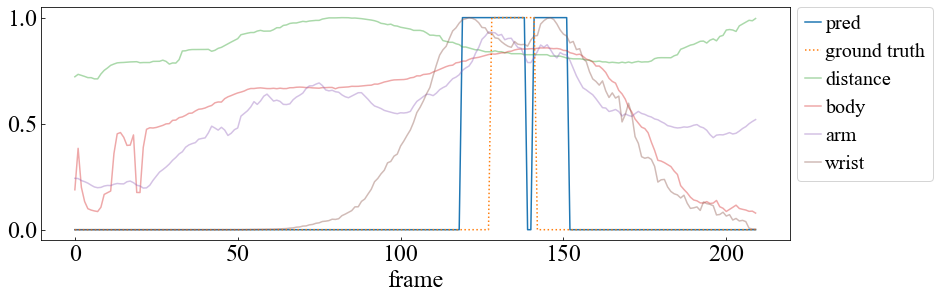

02_19_0_4


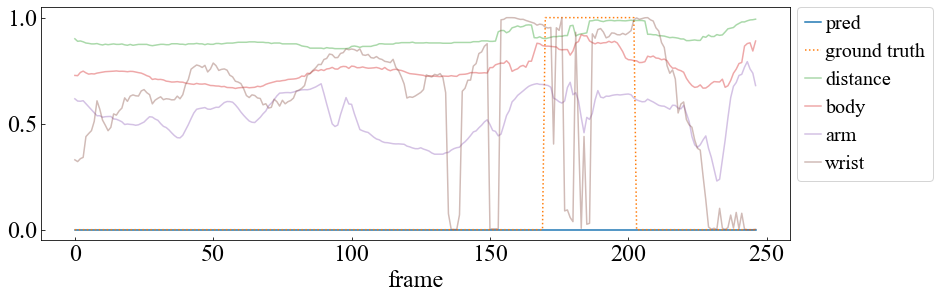

09_05_8_13


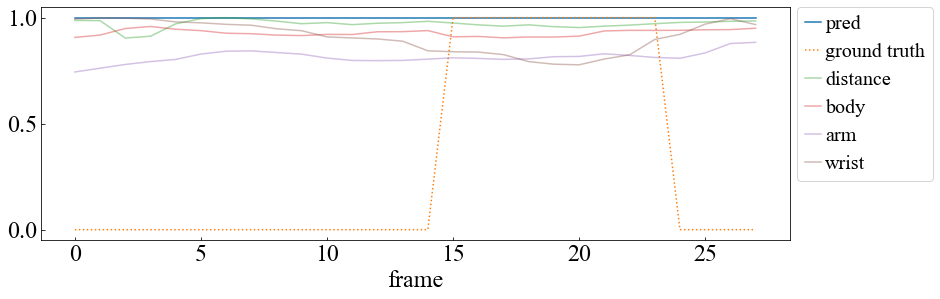

02_05_0_4


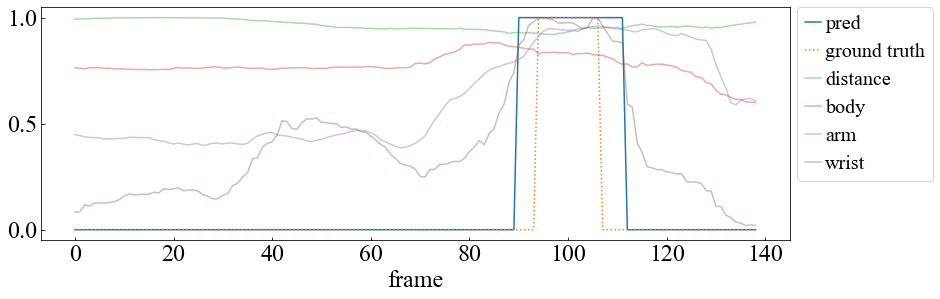

08_23_0_4


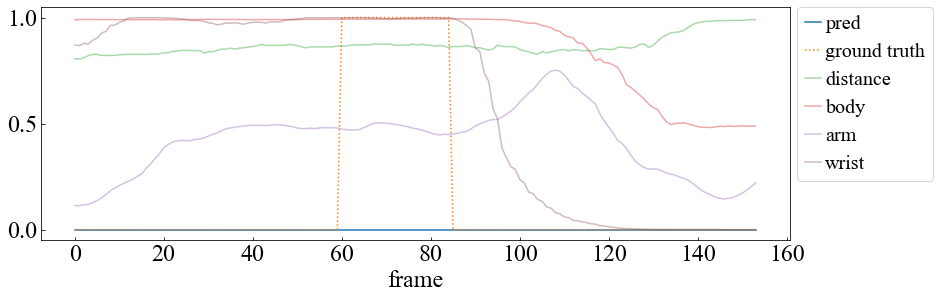

08_39_0_1


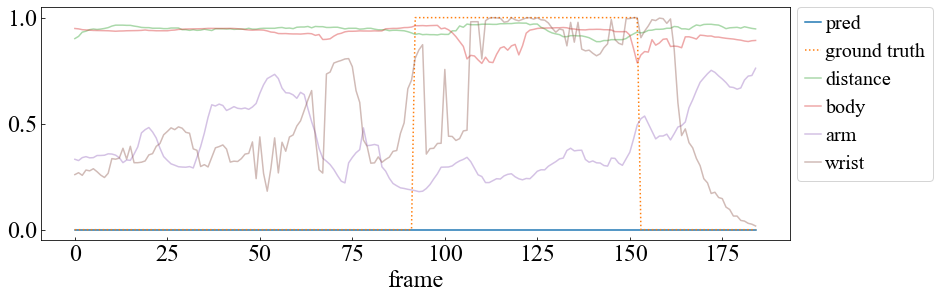

08_08_0_1


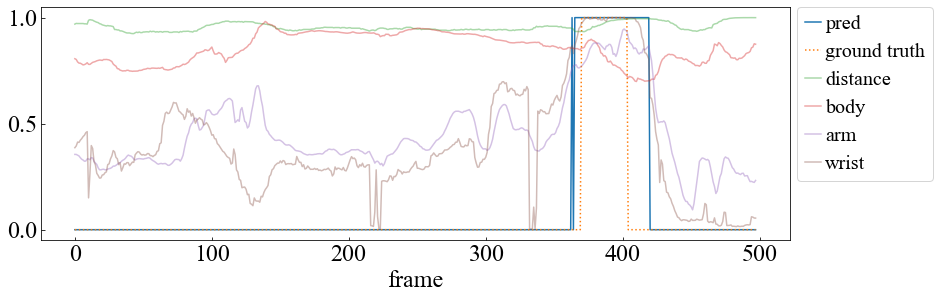

08_33_0_1


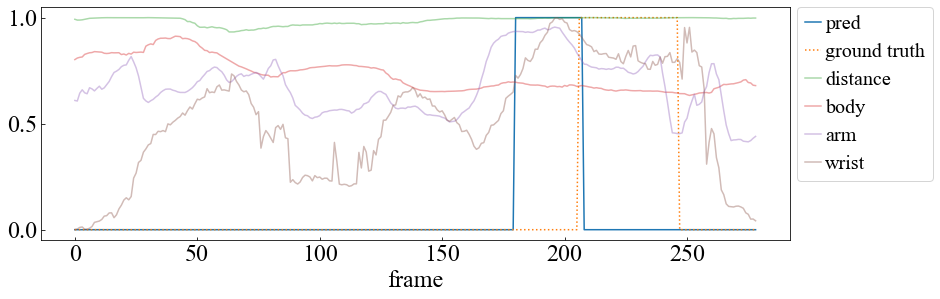

08_19_4_10


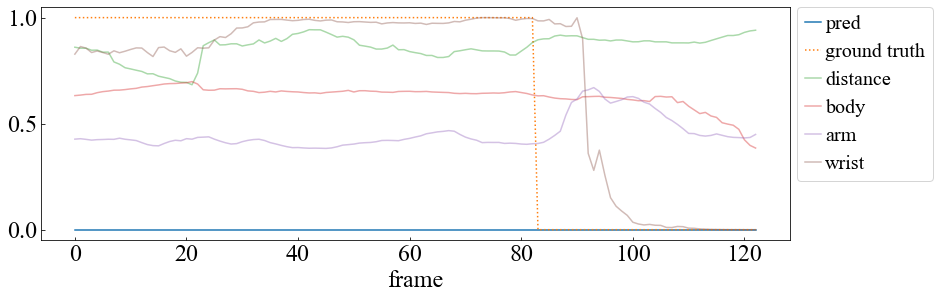

09_04_3_8


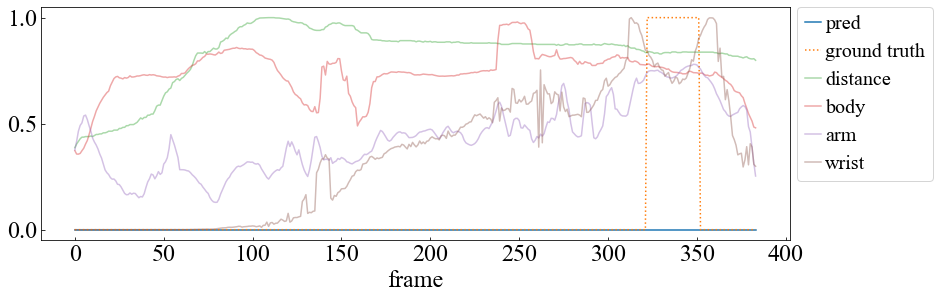

08_20_1_7


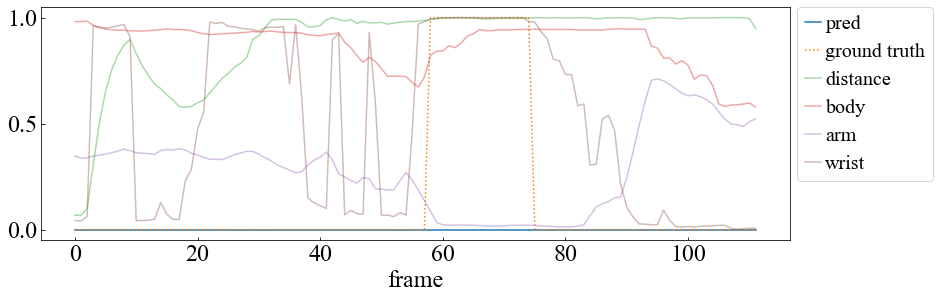

08_09_0_2


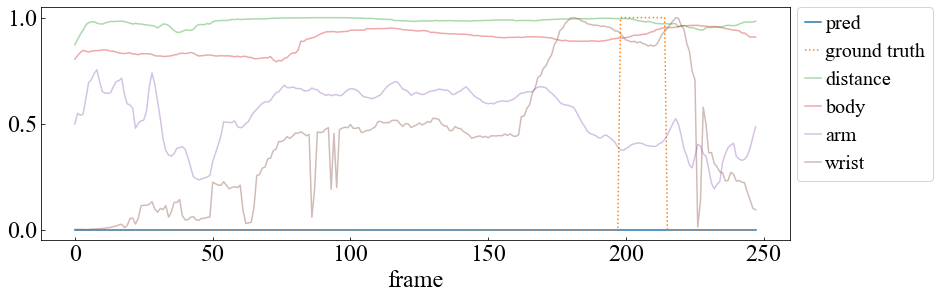

08_11_1_20


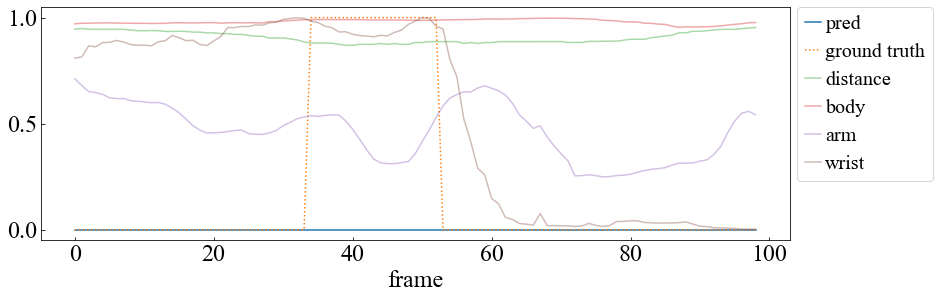

09_01_0_4


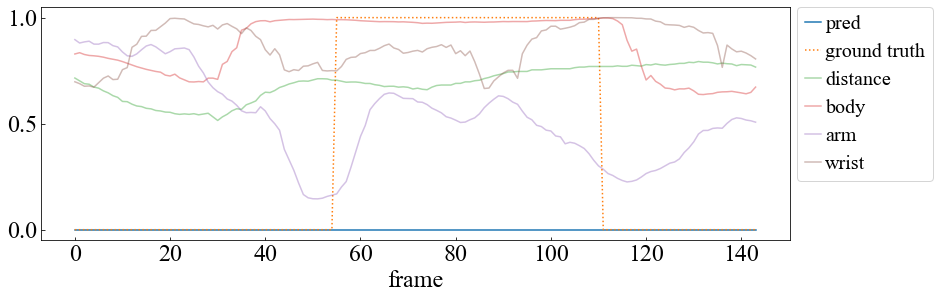

02_09_5_6


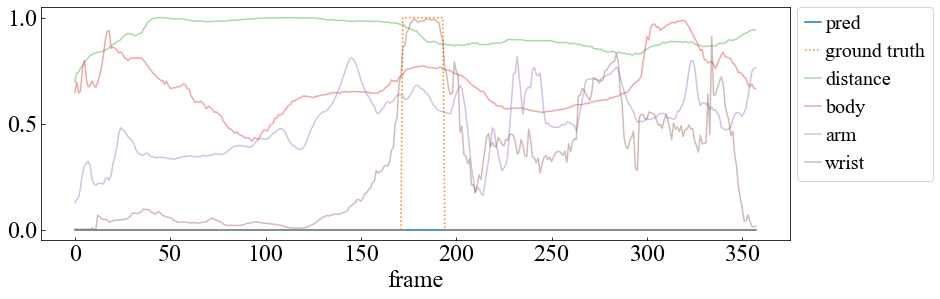

08_40_0_1


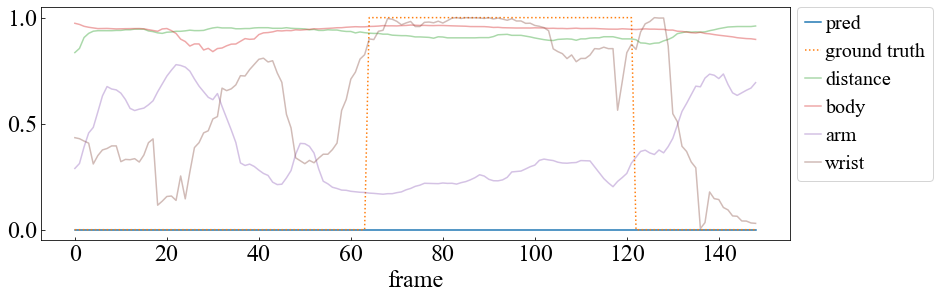

08_26_2_8


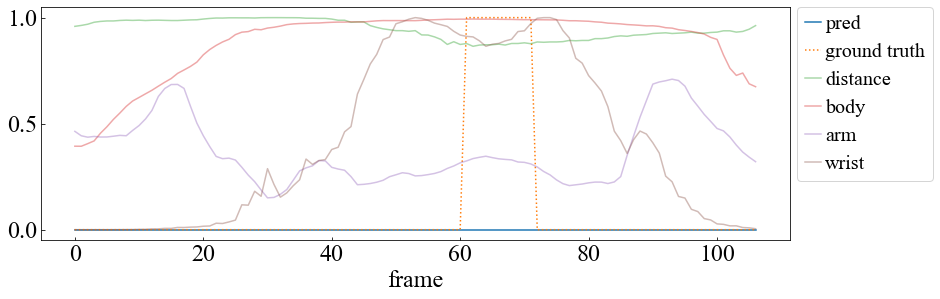

08_01_2_3


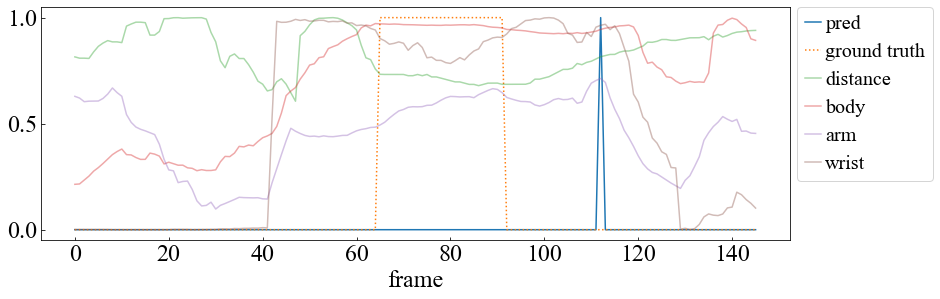

08_05_2_3


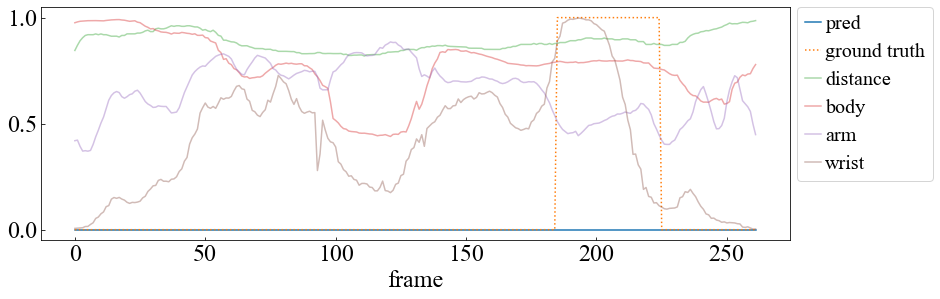

02_08_0_5


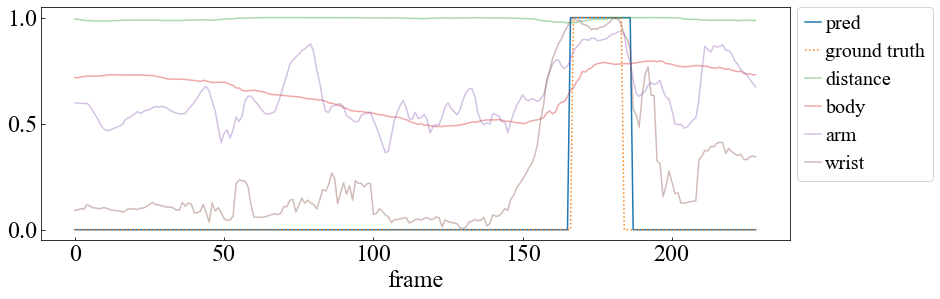

02_02_0_7


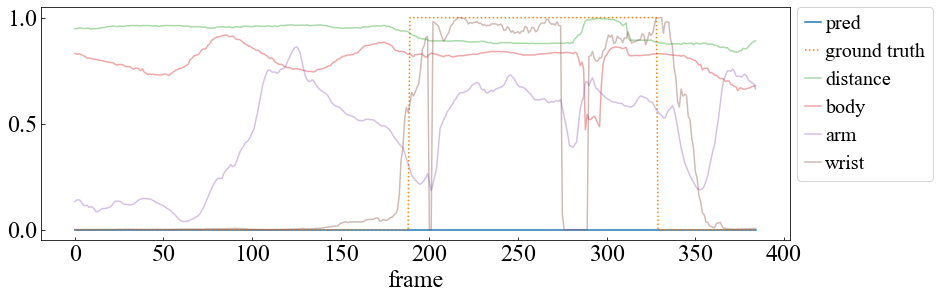

08_06_0_3


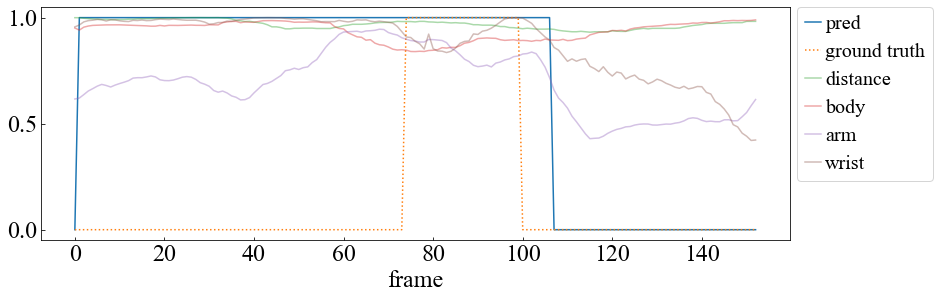

08_15_1_2


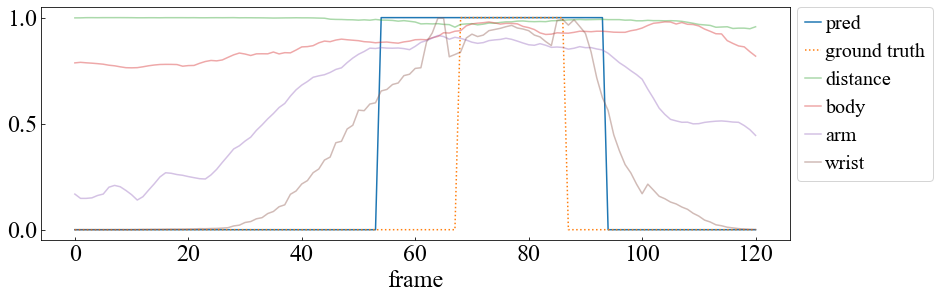

02_03_7_22


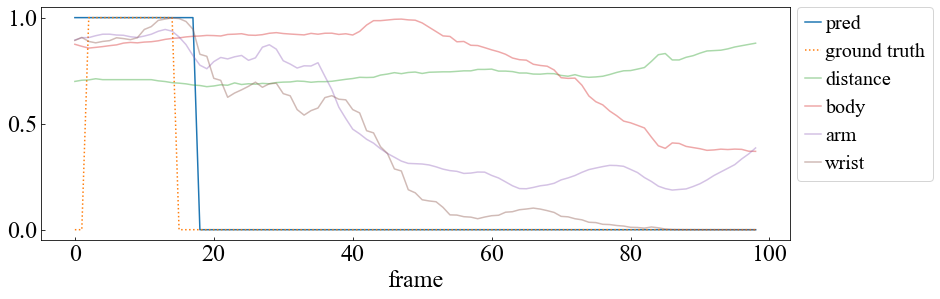

02_23_3_12


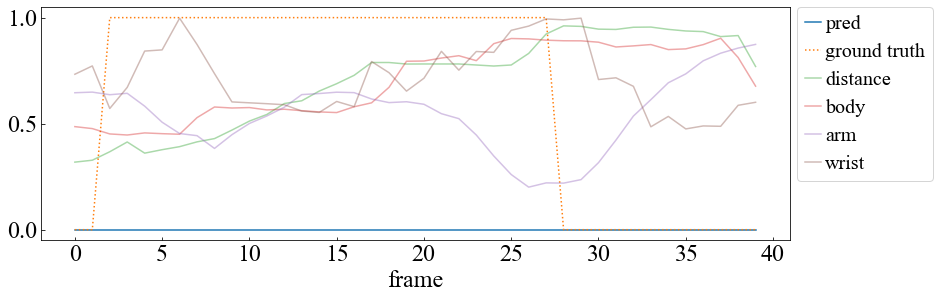

08_04_1_10


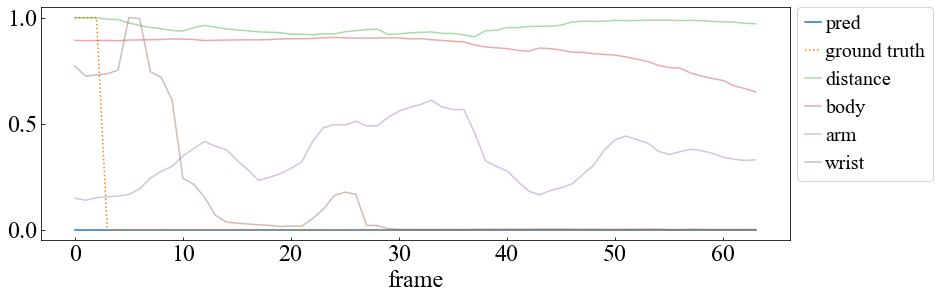

08_36_0_1


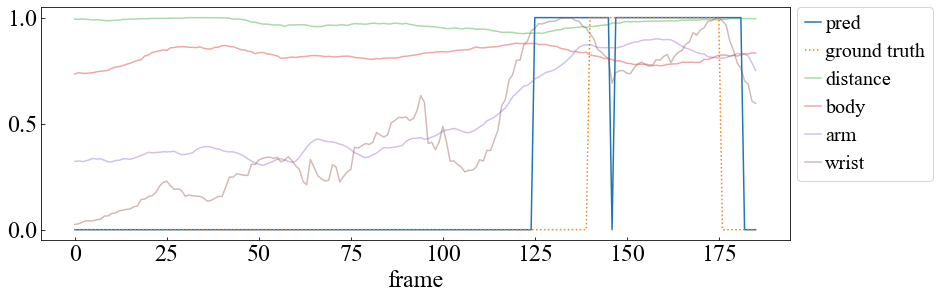

08_18_1_2


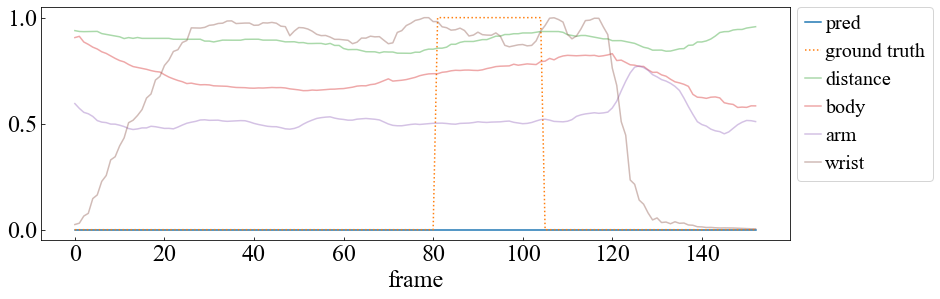

08_21_1_3


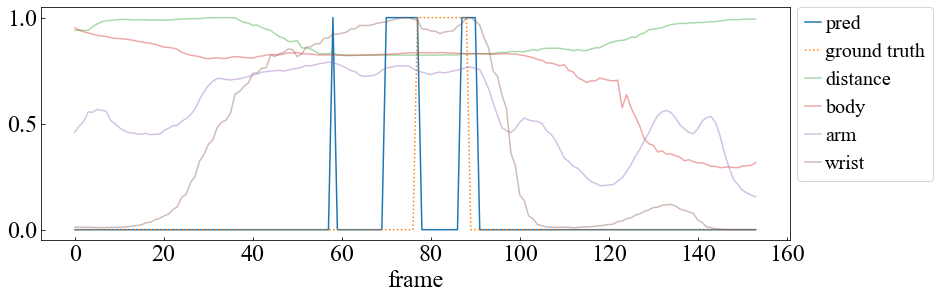

02_22_0_8


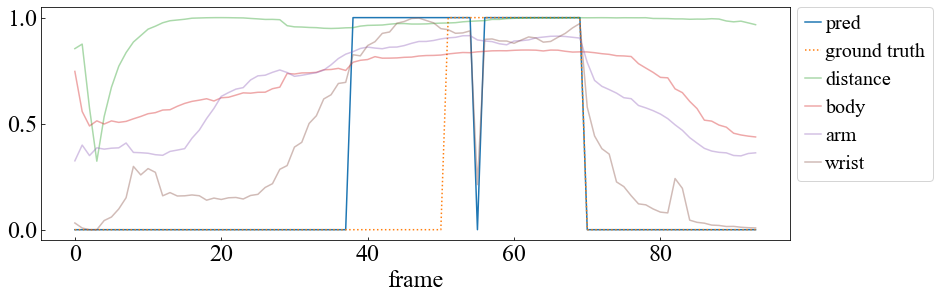

08_27_1_11


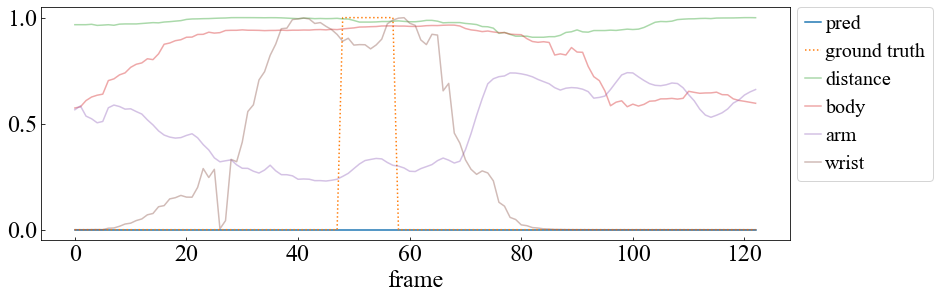

02_04_6_7


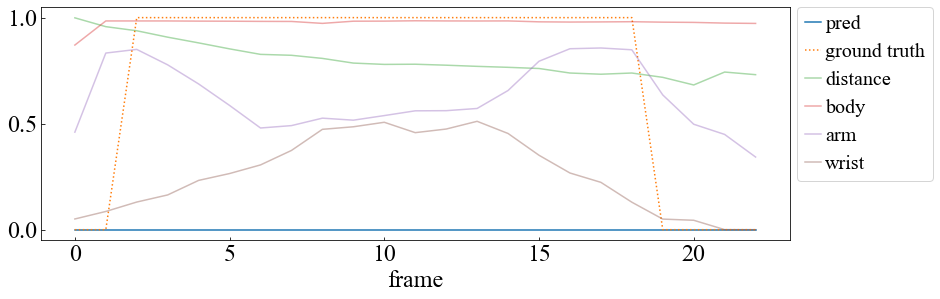

02_13_5_18


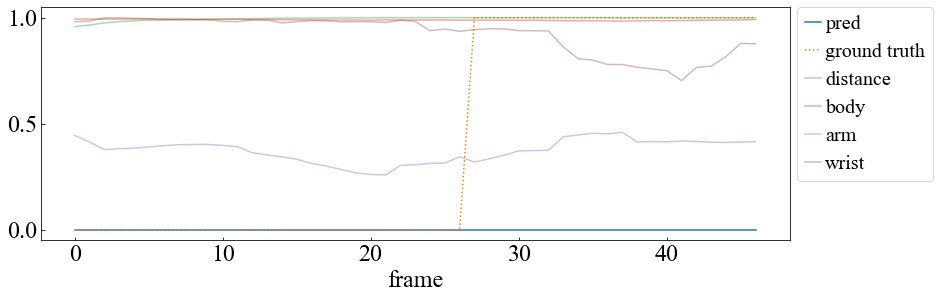

02_01_4_10


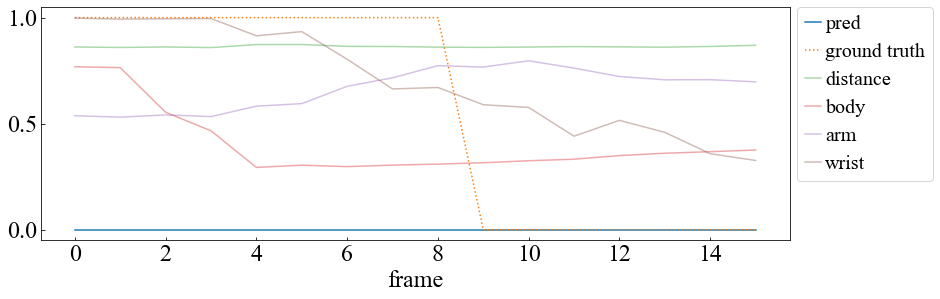

08_41_1_2


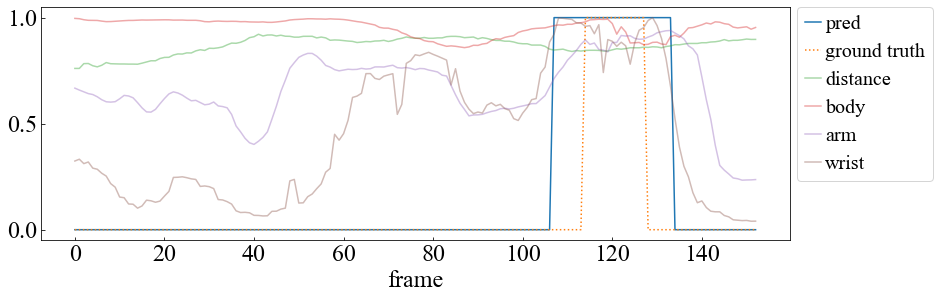

02_10_3_21


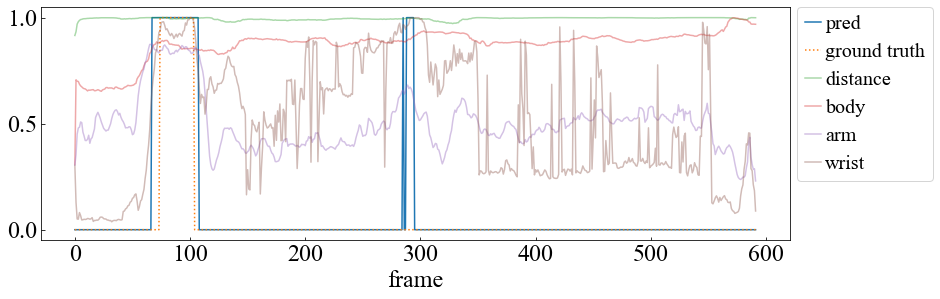

08_07_2_4


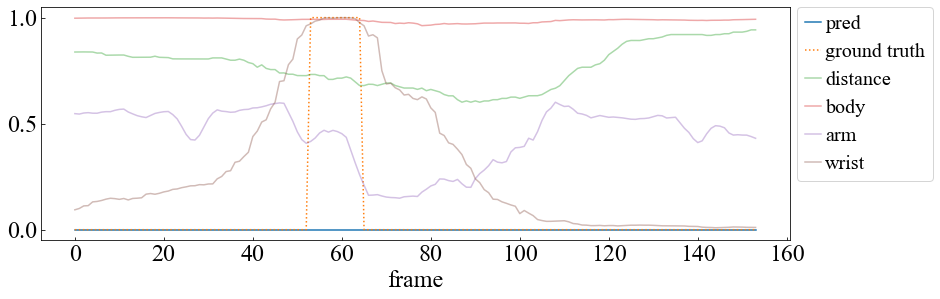

02_07_2_6


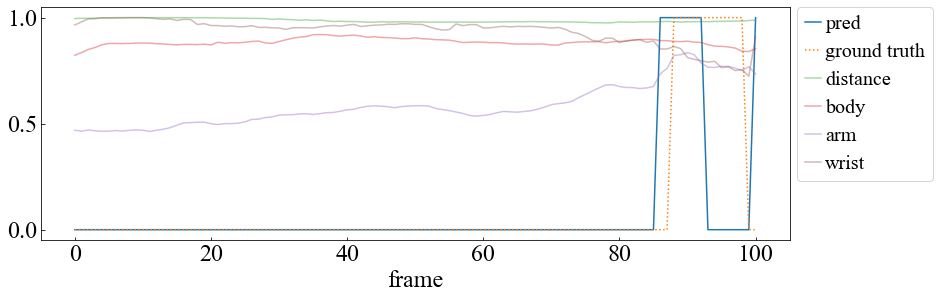

02_06_1_3


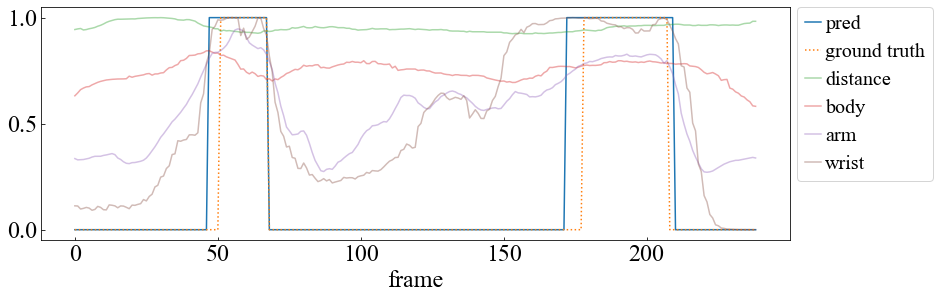

02_21_5_7


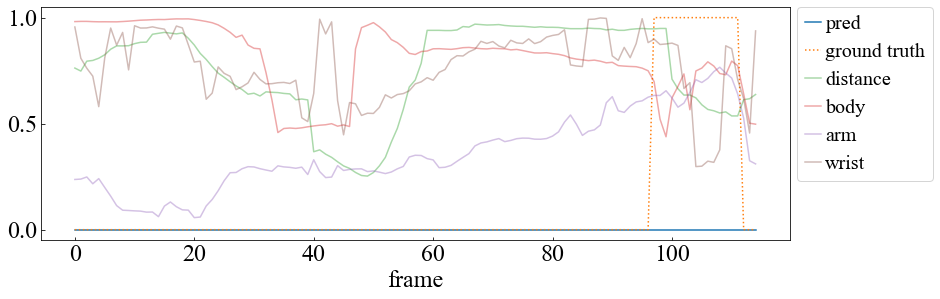

08_25_5_14


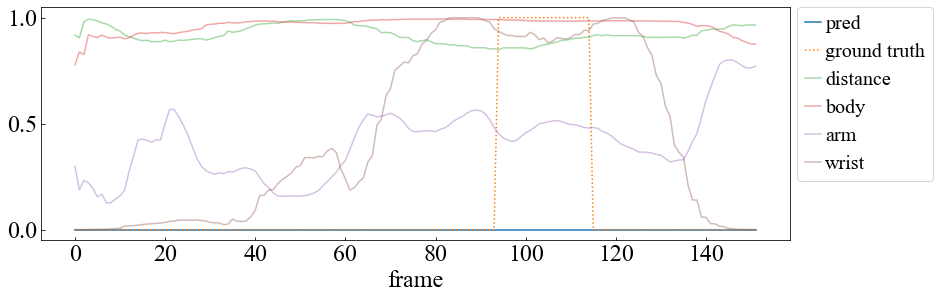

02_20_4_10


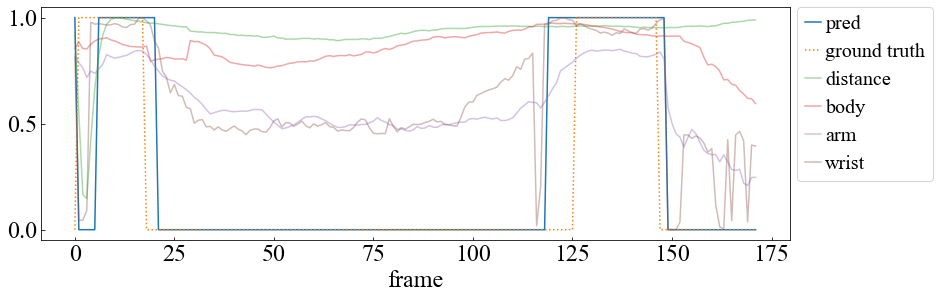

08_10_0_2


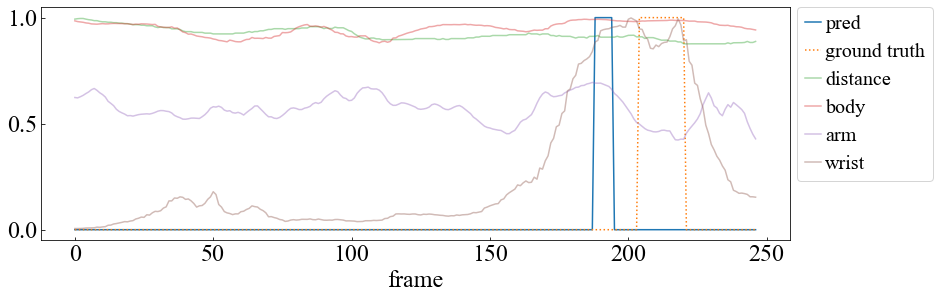

09_03_6_8


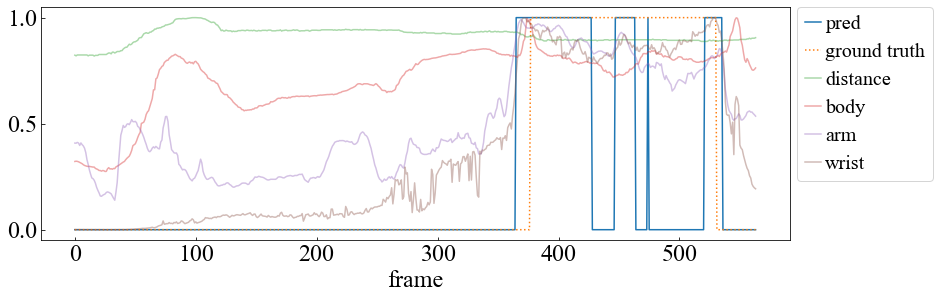

08_16_0_3


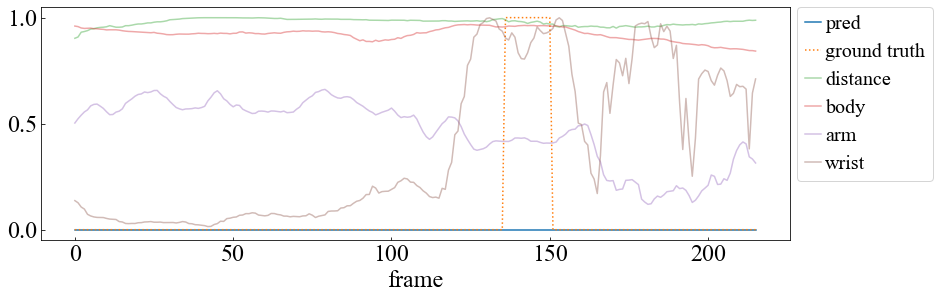

08_30_0_1


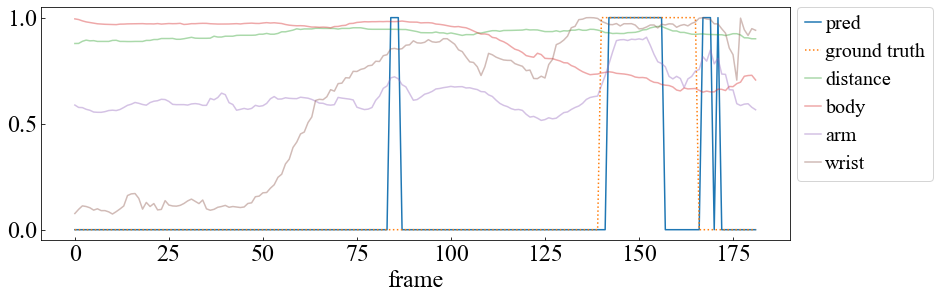

08_35_0_2


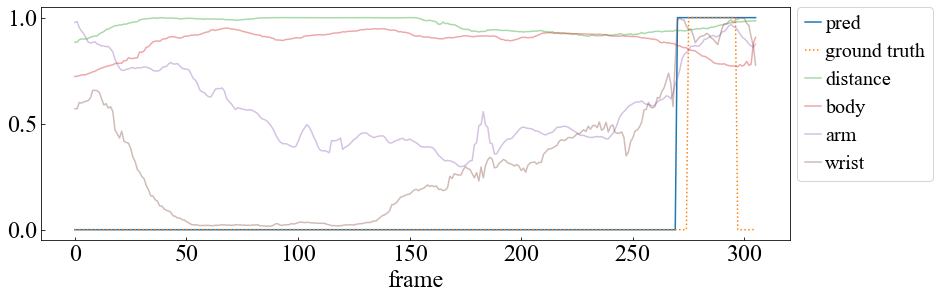

08_24_3_10


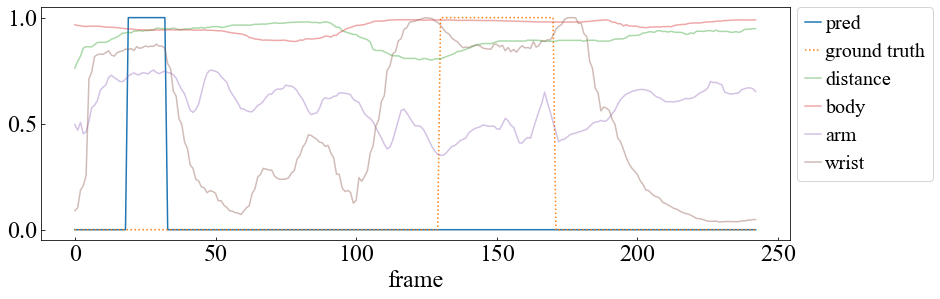

09_02_4_9


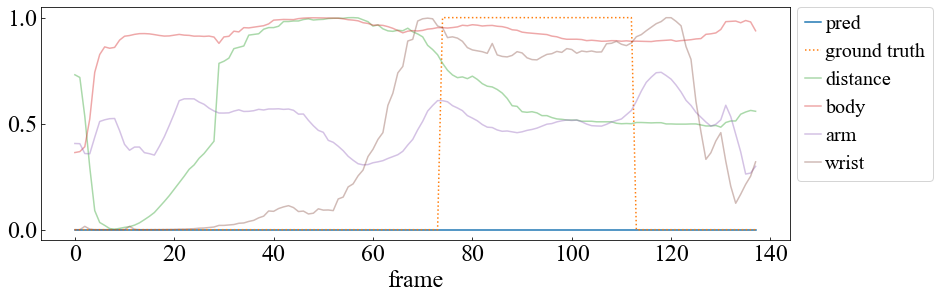

02_18_0_16


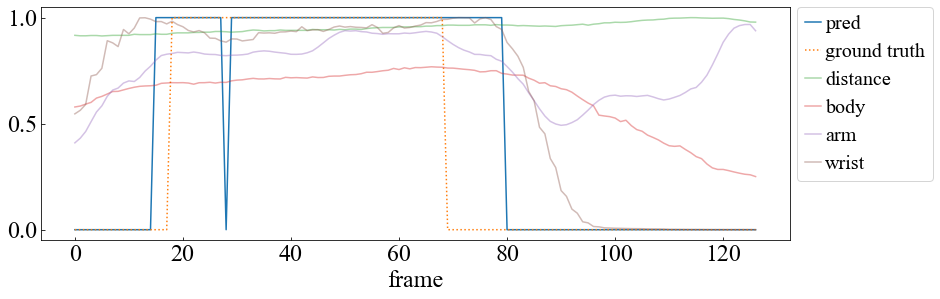

In [167]:
y_all_train = []
pred_all_train = []
y_eve_train = []
pred_eve_train = []

for key, x, y in zip(x_train_dict.keys(), x_train_dict.values(), y_train_dict.values()):
    pred = model.predict(x)
    
    y_all_train += y
    pred_all_train += pred.tolist()
    y_eve_train.append(1 in y)
    pred_eve_train.append(1 in pred.tolist())
    
    if len(x) == 0 or 1 not in y:
        continue
        
    print(key)
    path = ""
    plot(x, y, pred, path=None)

In [168]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_train, pred_all_train)))
print('precision: {:.3f}'.format(precision_score(y_all_train, pred_all_train)))
print('recall: {:.3f}'.format(recall_score(y_all_train, pred_all_train)))
print('f1_score: {:.3f}'.format(f1_score(y_all_train, pred_all_train)))

accuracy: 0.993
precision: 0.287
recall: 0.319
f1_score: 0.302


In [169]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_train, pred_eve_train)))
print('precision: {:.3f}'.format(precision_score(y_eve_train, pred_eve_train)))
print('recall: {:.3f}'.format(recall_score(y_eve_train, pred_eve_train)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_train, pred_eve_train)))

accuracy: 0.980
precision: 0.214
recall: 0.480
f1_score: 0.296


In [170]:
save_keys = [
    '08_03_2_5',
]

02_02_0_2


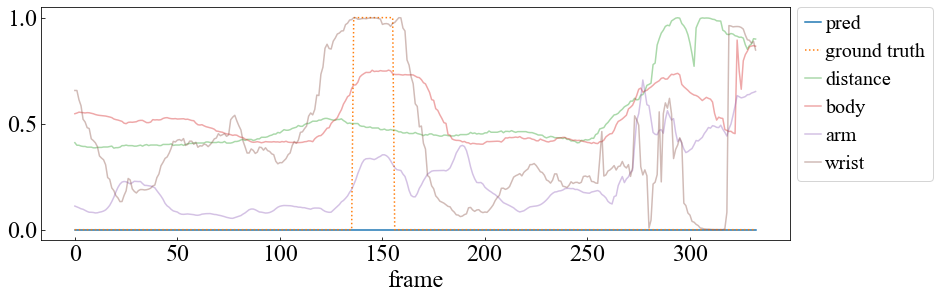

02_03_2_7


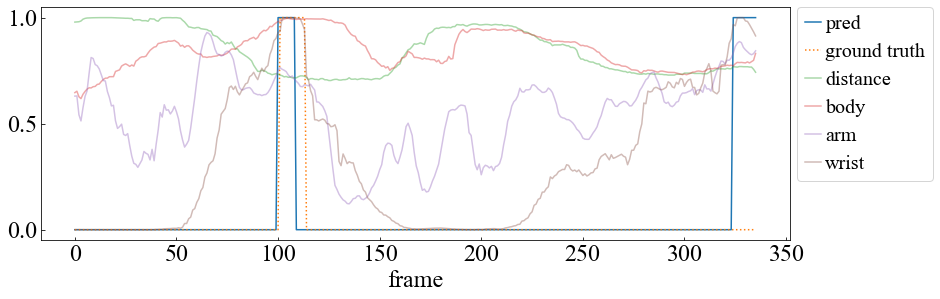

08_31_3_15


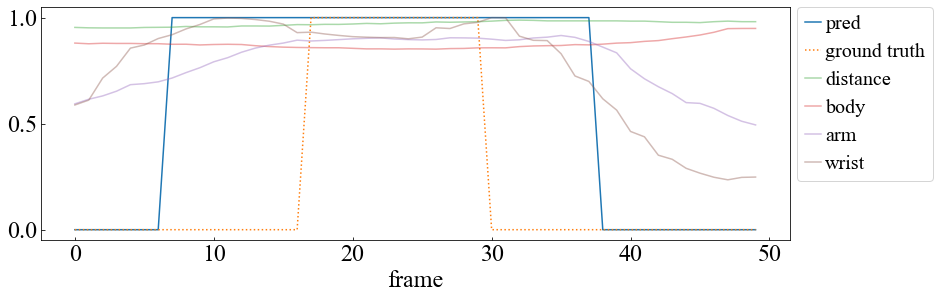

09_08_0_4


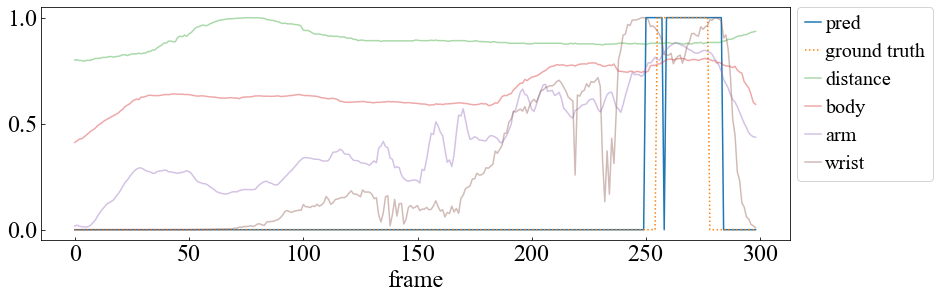

08_32_0_1


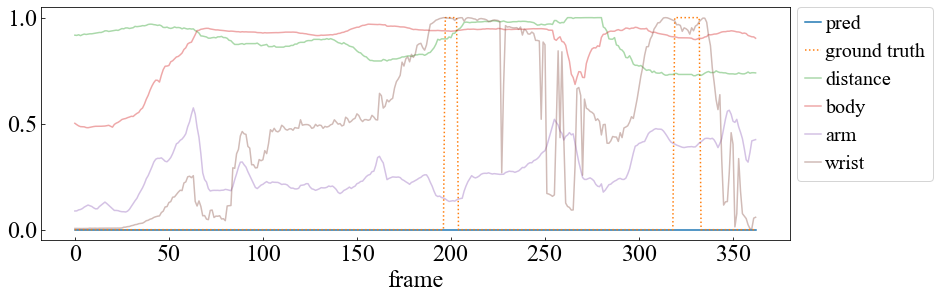

08_12_3_5


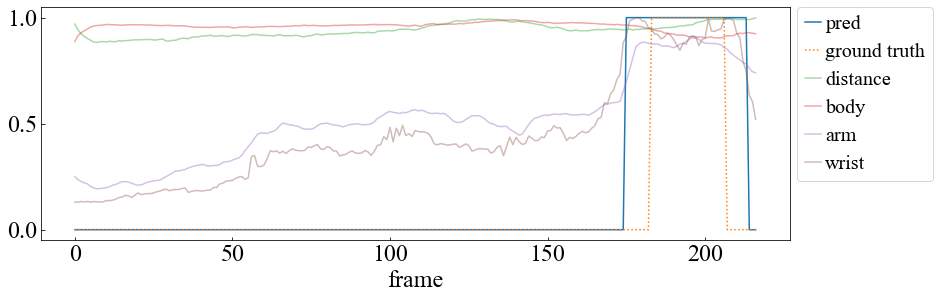

02_18_0_4


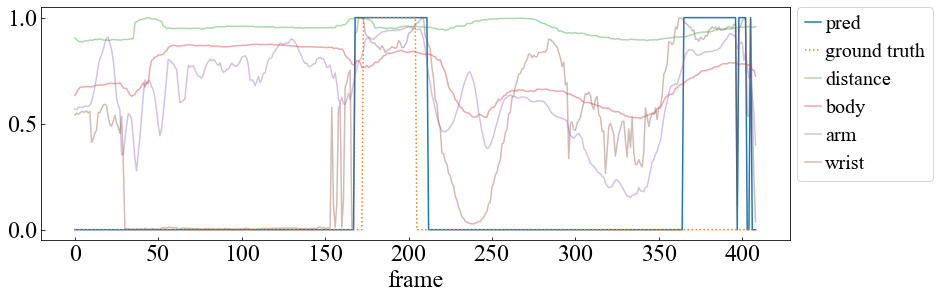

08_34_0_2


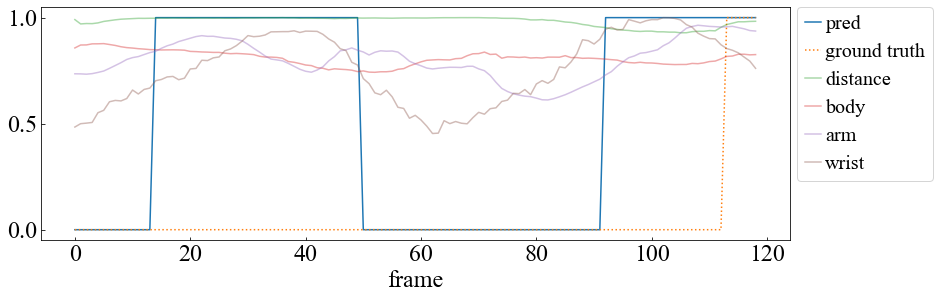

08_38_0_1


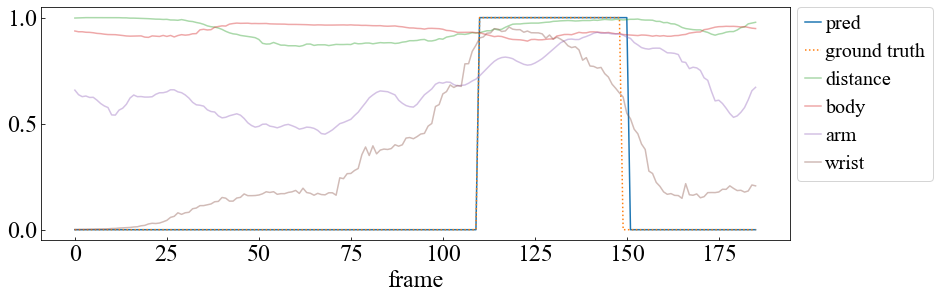

08_37_1_6


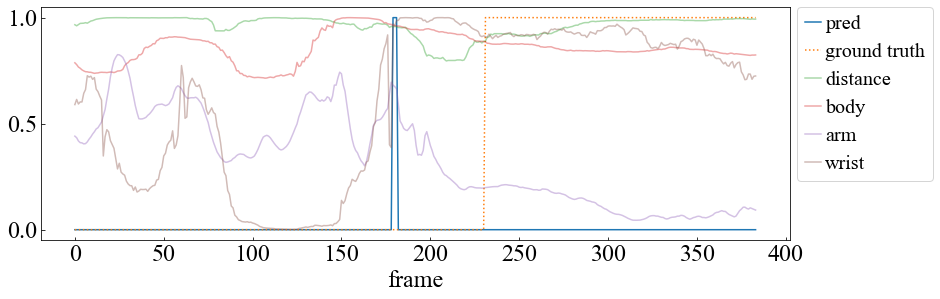

02_15_23_40


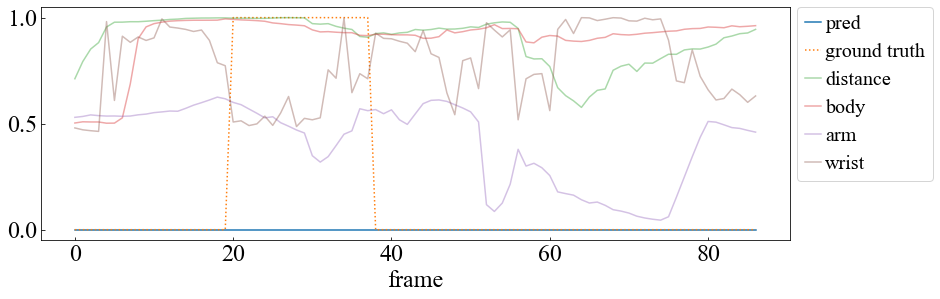

02_11_10_17


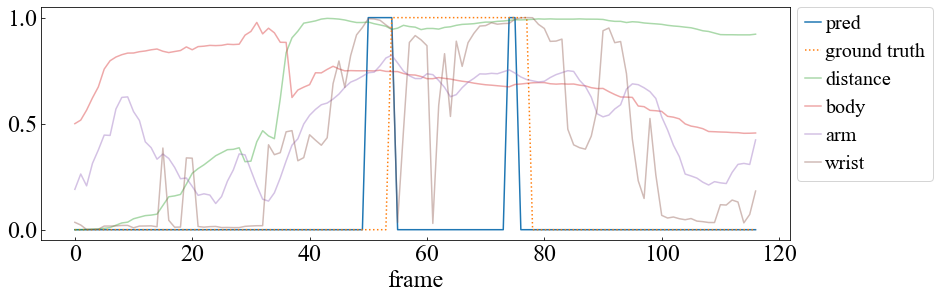

08_13_2_3


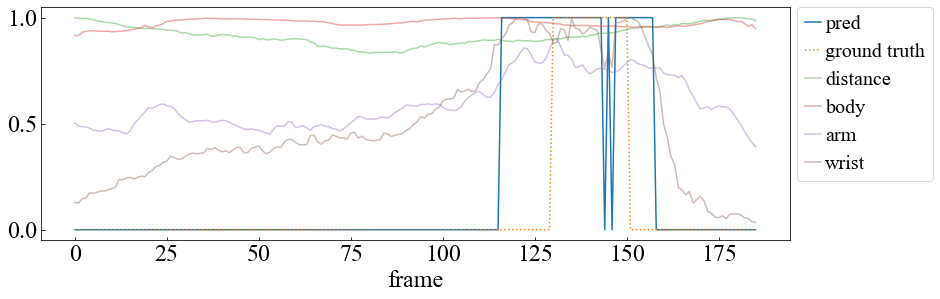

08_29_0_2


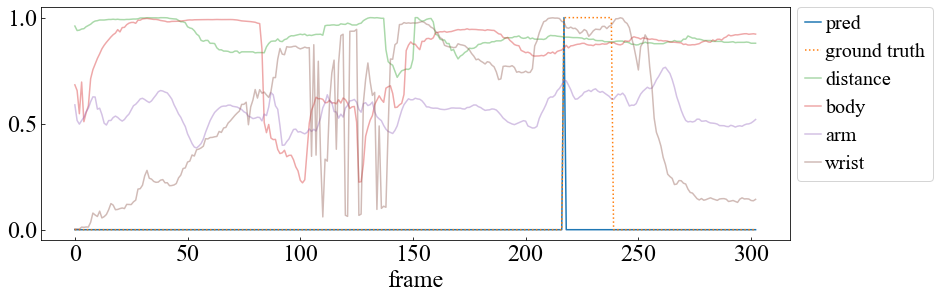

08_14_2_4


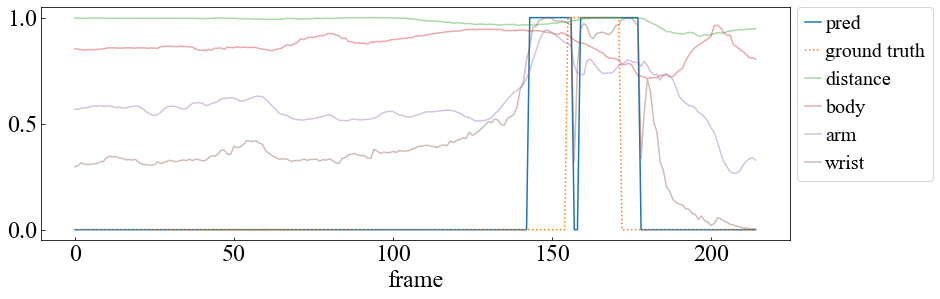

08_17_1_2


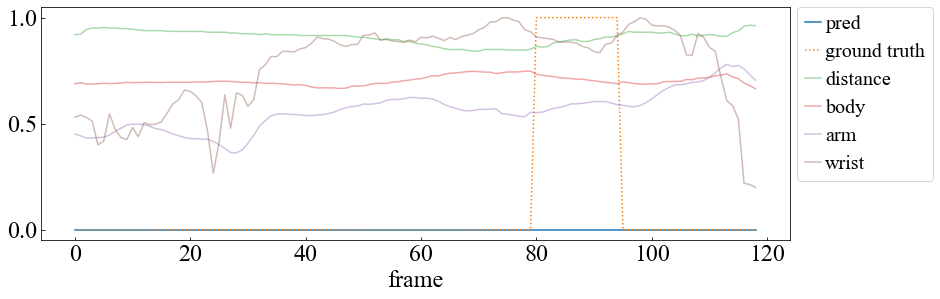

09_09_1_9


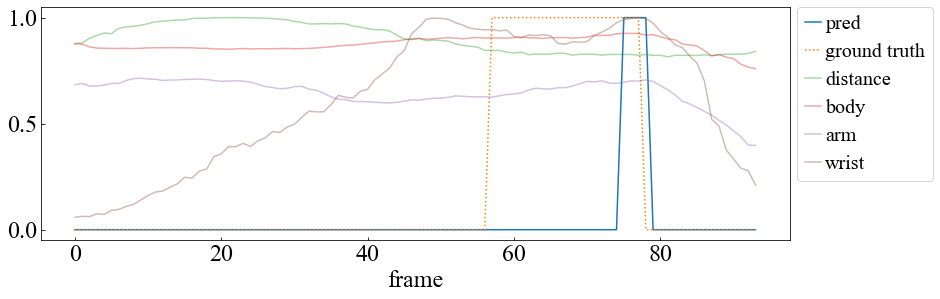

08_03_2_5


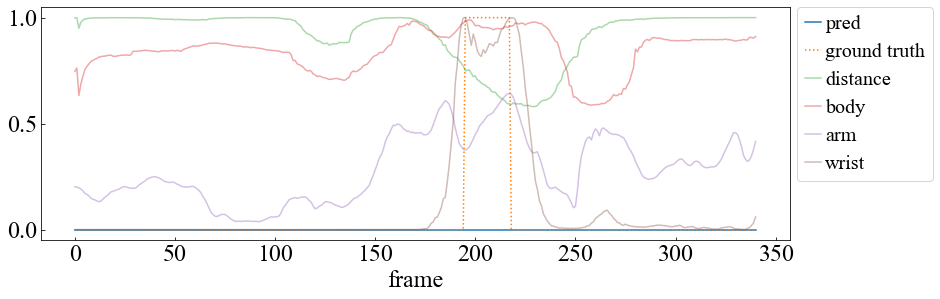

In [171]:
y_all_test = []
pred_all_test = []
y_eve_test = []
pred_eve_test = []

for key, x, y in zip(x_test_dict.keys(), x_test_dict.values(), y_test_dict.values()):
    pred = model.predict(x)
    
    y_all_test += y
    pred_all_test += pred.tolist()
    y_eve_test.append(1 in y)
    pred_eve_test.append(1 in pred.tolist())
    
    if len(x) == 0 or 1 not in y:
        continue
        
    print(key)
    path = None
    if key in save_keys:
        path = os.path.join(common.data_dir, "image", "passing", f"svm_test_{key}.pdf")
    plot(x, y, pred, path=path)

In [172]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

# cm = confusion_matrix(y_all_test, pred_all_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.995
precision: 0.355
recall: 0.366
f1_score: 0.361


In [173]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_test, pred_eve_test)))
print('precision: {:.3f}'.format(precision_score(y_eve_test, pred_eve_test)))
print('recall: {:.3f}'.format(recall_score(y_eve_test, pred_eve_test)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_test, pred_eve_test)))

# cm = confusion_matrix(y_eve_test, pred_eve_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.984
precision: 0.277
recall: 0.722
f1_score: 0.400


# パラメータ調整

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss
from tqdm import tqdm

In [176]:
params = {
    'C': np.arange(0.1, 1.1, 0.1),
    'gamma': np.arange(0.01, 1.01, 0.01)
}

max_score = 0
min_score = np.inf
auc_param = {}
logloss_param = {}
for c in params['C']:
    print('C:', c)
    for gamma in tqdm(params['gamma']):
        model = SVC(C=c, gamma=gamma)
        model.fit(x_train_new, y_train_new)
        pred = model.predict(x_test)
        
        try:
            score = roc_auc_score(pred, y_test)
            if score > max_score:
                max_score = score
                auc_param = {'C': c, 'gamma': gamma}

            score = log_loss(pred, y_test)
            if score < min_score:
                min_score = score
                logloss_param = {'C': c, 'gamma': gamma}
        except ValueError:
            continue
            
    print('max auc score: {}, C: {}, gamma: {}'.format(max_score, auc_param['C'], auc_param['gamma']))
    print('min logloss score: {}, C: {}, gamma: {}'.format(min_score, logloss_param['C'], logloss_param['gamma']))

C: 0.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:02<00:00, 11.42s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:13<00:00, 10.34s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.30000000000000004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:27<00:00,  9.87s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:02<00:00,  9.63s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:03<00:00,  9.64s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:51<00:00,  9.52s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.7000000000000001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:23<00:00,  9.23s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:10<00:00,  9.11s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 0.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:04<00:00,  9.05s/it]


max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
C: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:00<00:00,  9.00s/it]

max auc score: 0.673604304567084, C: 0.1, gamma: 0.02
min logloss score: 0.17899151165933147, C: 0.1, gamma: 0.02
